## 导入工具库

In [605]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
from scipy import stats
import itertools
#Scikit-Learn for Modeling
from sklearn import model_selection
from sklearn import metrics
from time import time
import myvisuals as vs
from datetime import datetime
import random
import xgboost as xgb

## 导入数据

In [606]:
df_train = pd.read_csv("train.csv", parse_dates=[2], low_memory=False)
df_test = pd.read_csv("test.csv", parse_dates=[3], low_memory=False)
df_store = pd.read_csv("store.csv", low_memory=False)

print "store dataset has {} rows with {} features each.".format(*df_store.shape)
print "train dataset has {} rows with {} features each.".format(*df_train.shape)
print "test dataset has {} data points with {} variables each.".format(*df_test.shape)

store dataset has 1115 rows with 10 features each.
train dataset has 1017209 rows with 9 features each.
test dataset has 41088 data points with 8 variables each.


## 预处理数据

### 处理异常值

In [609]:
df_train=df_train.drop(df_train[df_train.Sales == 0].index)
df_train = df_train.reset_index(drop=True) 

In [610]:
def rm_outliers(df): 
    q1 = np.percentile(df['Sales'], 25, axis=0)
    q3 = np.percentile(df['Sales'], 75, axis=0)
    k = 2.5
    iqr = q3 - q1
    df = df[(df['Sales'] > q1 - k*iqr) & (df['Sales'] < q3 + k*iqr)]
    return df

df_train = rm_outliers(df_train)
df_train['LogSales'] = np.log1p(df_train['Sales'])

### train & test

In [611]:
# add a flag variable to distinguish train and test dataset
df_train['Set'] = 1
df_test['Set'] = 0
# combine the train and test set 
df_train_test = pd.concat([df_train, df_test], sort = False)

# convert number 0 in column 'StateHoliday' to string '0'
df_train_test.loc[df_train_test['StateHoliday'] == 0, 'StateHoliday'] = '0'

# seperate out the elements of the date column for train and test set
df_train_test["Year"] = df_train_test["Date"].dt.year
df_train_test["Month"] = df_train_test["Date"].dt.month
df_train_test["DayOfMonth"] = df_train_test["Date"].dt.day
df_train_test["WeekOfYear"] = df_train_test["Date"].dt.weekofyear
df_train_test["DayOfYear"] = df_train_test["Date"].dt.dayofyear

df_train_test['DayOfWeek'] = df_train_test['DayOfWeek'].astype('category').cat.codes

# Fill out NaN values with 1 in column 'Open' for test set
df_train_test.loc[df_train_test['Open'].isnull(), 'Open'] = 1

# Label encoding using panda category datatype. Label encoded Assortment and StoreType
df_train_test['StateHoliday'] = df_train_test['StateHoliday'].astype('category').cat.codes

# Label encoding using panda category datatype. Label encoded Assortment and StoreType
df_train_test['StateHoliday'] = df_train_test['StateHoliday'].astype('category').cat.codes

### store

In [612]:
df_store.loc[df_store["CompetitionDistance"].isnull(), 'CompetitionDistance'] = 0
df_store.loc[df_store["CompetitionOpenSinceYear"].isnull(),'CompetitionOpenSinceYear'] = 2010
df_store.loc[df_store["CompetitionOpenSinceMonth"].isnull(),'CompetitionOpenSinceMonth'] = 1
df_store.loc[df_store["PromoInterval"].isnull(), "PromoInterval"] = 0


df_store['Assortment'] = df_store['Assortment'].astype('category').cat.codes
df_store['StoreType'] = df_store['StoreType'].astype('category').cat.codes
df_store['Assortment'] = df_store['Assortment'].astype('category').cat.codes
df_store['StoreType'] = df_store['StoreType'].astype('category').cat.codes

### merge

In [613]:
processed_df = pd.merge(df_train_test, df_store, how='left', on='Store')

## 特征提取

* Xun

In [ ]:
# add Xun
# features.append('Xun')
# xun_conditions = [(((data["DayOfMonth"] >= 1) & (data["DayOfMonth"] < 11))),(((data["DayOfMonth"] >= 11) & (data["DayOfMonth"] < 21))),(((data["DayOfMonth"] >= 21) & (data["DayOfMonth"] <= 31)))]
# choices = ['begin', 'middle', 'end']
# data['Xun'] = np.select(xun_conditions, choices, default='Error')

* Season

In [ ]:
# add Season
# features.append('Season')
# season_conditions = [
#     (((data["Month"] == 3) & (data["DayOfMonth"] >= 22)) | ((3 < data["Month"]) & (data["Month"] < 6)) | ((data["Month"] == 6) & (data["DayOfMonth"] < 22))),
#     (((data["Month"] == 6) & (data["DayOfMonth"] >= 22)) | ((6 < data["Month"]) & (data["Month"] < 9)) | ((data["Month"] == 9) & (data["DayOfMonth"] < 22))),
#     (((data["Month"] == 9) & (data["DayOfMonth"] >= 22)) | ((9 < data["Month"]) & (data["Month"] < 12)) | ((data["Month"] == 12) & (data["DayOfMonth"] < 22))),
#     (((data["Month"] == 12) & (data["DayOfMonth"] >= 22)) | ((data["Month"] >= 1) & (data["Month"] < 3)) | ((data["Month"] == 3) & (data["DayOfMonth"] < 22)))
# ]
# choices = ['spring', 'summer', 'autumn','winter']
# data['Season'] = np.select(season_conditions, choices, default='Error')

In [115]:
# features_df['Xun']= features_df['Xun'].astype('category')
# features_df['Season']= features_df['Season'].astype('category')

# features_df['Xun_cat'] = features_df['Xun'].cat.codes
# features_df['Season_cat'] = features_df['Season'].cat.codes

# features_df['Xun_cat'] = features_df['Xun_cat'].astype('float')
# features_df['Season_cat'] = features_df['Season_cat'].astype('float')

# features_df=pd.get_dummies(features_df, columns=["Xun","Season"], prefix=["is_Xun","is_Season"])

# del features_df['Xun_cat']
# del features_df['Season_cat']

* Promo2OpenInMonth

In [614]:
# Promo2 open time in months
processed_df['Promo2OpenInMonth'] = 12 * (processed_df.Year - processed_df.Promo2SinceYear) + (processed_df.WeekOfYear - processed_df.Promo2SinceWeek) / 4.0
processed_df['Promo2OpenInMonth'] = processed_df.Promo2OpenInMonth.apply(lambda x: x if x > 0 else 0)
processed_df.loc[processed_df.Promo2SinceYear == 0, 'Promo2OpenInMonth'] = 0

* IsPromo2Month

In [615]:
month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
processed_df['MonthStr'] = processed_df.Month.map(month2str)
processed_df.loc[processed_df.PromoInterval == 0, 'PromoInterval'] = ''
processed_df['IsPromo2Month'] = 0
for interval in processed_df.PromoInterval.unique():
    if interval != '':
        for month in interval.split(','):
            processed_df.loc[(processed_df.MonthStr == month) & (processed_df.PromoInterval == interval), 'IsPromo2Month'] = 1

* CompetitionOpenInMonth

In [616]:
processed_df['CompetitionOpenInMonth'] = 12 * (processed_df.Year - processed_df.CompetitionOpenSinceYear) + (processed_df.Month - processed_df.CompetitionOpenSinceMonth)   

processed_df = processed_df.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear'], 
                 axis=1) 

* AvgSalesPerStore / AvgCustomersPerStore 

In [617]:
df_train = preprocessed_df[preprocessed_df['Set'] == 1]

AvgSalesPerStore = df_train.groupby([df_train['Store']])['Sales'].mean()
AvgCustomersPerStore = df_train.groupby([df_train['Store']])['Customers'].mean()

processed_df = pd.merge(processed_df, AvgSalesPerStore.reset_index(name='AvgSalesPerStore'), how='left', on=['Store'])
processed_df = pd.merge(processed_df, AvgCustomersPerStore.reset_index(name='AvgCustomersPerStore'), how='left', on=['Store'])

* AvgSalesPerStore_Promo / AvgCustomersPerStore_Promo

In [618]:
df_promo = df_train[df_train['Promo'] == 1]

AvgSalesPerStore_Promo = df_promo.groupby([df_train['Store']] )['Sales'].mean()
AvgCustomersPerStore_Promo = df_promo.groupby([df_train['Store']] )['Customers'].mean()

processed_df = pd.merge(processed_df, AvgSalesPerStore_Promo.reset_index(name='AvgSalesPerStore_Promo'), how='left', on=['Store'])
processed_df = pd.merge(processed_df, AvgCustomersPerStore_Promo.reset_index(name='AvgCustomersPerStore_Promo'), how='left', on=['Store'])

* AvgSalesPerStore_No_Promo / AvgCustomersPerStore_No_Promo

In [619]:
df_no_promo = df_train[df_train['Promo'] == 0]


AvgSalesPerStore_No_Promo = df_no_promo.groupby([df_train['Store']] )['Sales'].mean()
AvgCustomerPerStore_No_Promo = df_no_promo.groupby([df_train['Store']] )['Customers'].mean()

processed_df = pd.merge(processed_df, AvgSalesPerStore_No_Promo.reset_index(name='AvgSalesPerStore_No_Promo'), how='left', on=['Store'])
processed_df = pd.merge(processed_df, AvgCustomerPerStore_No_Promo.reset_index(name='AvgCustomerPerStore_No_Promo'), how='left', on=['Store'])

* AvgSales_2013 / AvgCustomers_2013

In [620]:
df_2013 = df_train[df_train['Year'] == 2013]

AvgSales_2013 =  df_2013.groupby([df_2013['Store']])['Sales'].mean()
AvgCustomers_2013 =  df_2013.groupby([df_2013['Store']])['Customers'].mean()

processed_df = pd.merge(processed_df, AvgSales_2013.reset_index(name='AvgSales_2013'), how='left', on=['Store'])
processed_df = pd.merge(processed_df, AvgCustomers_2013.reset_index(name='AvgCustomers_2013'), how='left', on=['Store'])

* AvgSales_2014 / AvgCustomers_2014

In [621]:
df_2014 = df_train[df_train['Year'] == 2014]

AvgSales_2014 =  df_2014.groupby([df_2014['Store']])['Sales'].mean()
AvgCustomers_2014 =  df_2014.groupby([df_2014['Store']])['Customers'].mean()

processed_df = pd.merge(processed_df, AvgSales_2014.reset_index(name='AvgSales_2014'), how='left', on=['Store'])
processed_df = pd.merge(processed_df, AvgCustomers_2014.reset_index(name='AvgCustomers_2014'), how='left', on=['Store'])

* AvgSales_2015 / AvgCustomers_2015

In [622]:
df_2015 = df_train[df_train['Year'] == 2015]

AvgSales_2015 =  df_2015.groupby([df_2015['Store']])['Sales'].mean()
AvgCustomers_2015 =  df_2015.groupby([df_2015['Store']])['Customers'].mean()

processed_df = pd.merge(processed_df, AvgSales_2015.reset_index(name='AvgSales_2015'), how='left', on=['Store'])
processed_df = pd.merge(processed_df, AvgCustomers_2015.reset_index(name='AvgCustomers_2015'), how='left', on=['Store'])

* AvgSales_1(2,3,6)_Month_before / AvgCustomers_1(2,3,6)_Month_before

In [623]:
df_1month_before = df_train[(df_train['Month'] == 7) & (df_train['Year'] == 2015)]
df_2month_before = df_train[(df_train['Month'] <= 7) ^(df_train['Month'] >= 6) & (df_train['Year'] == 2015)]
df_3month_before = df_train[(df_train['Month'] <= 7) ^(df_train['Month'] >= 5) & (df_train['Year'] == 2015)]
df_6month_before = df_train[(df_train['Month'] <= 7) ^(df_train['Month'] >= 5) & (df_train['Year'] == 2015)]

AvgSales_1_Month_before = df_1month_before.groupby([df_1month_before['Store']])['Sales'].mean()
AvgSales_2_Month_before = df_2month_before.groupby([df_2month_before['Store']])['Sales'].mean()
AvgSales_3_Month_before = df_3month_before.groupby([df_3month_before['Store']])['Sales'].mean()
AvgSales_6_Month_before = df_6month_before.groupby([df_6month_before['Store']])['Sales'].mean()

processed_df = pd.merge(processed_df, AvgSales_1_Month_before.reset_index(name='AvgSales_1_Month_before'), how='left', on=['Store'])
processed_df = pd.merge(processed_df, AvgSales_2_Month_before.reset_index(name='AvgSales_2_Month_before'), how='left', on=['Store'])
processed_df = pd.merge(processed_df, AvgSales_3_Month_before.reset_index(name='AvgSales_3_Month_before'), how='left', on=['Store'])
processed_df = pd.merge(processed_df, AvgSales_6_Month_before.reset_index(name='AvgSales_6_Month_before'), how='left', on=['Store'])


AvgCustomers_1_Month_before = df_1month_before.groupby([df_1month_before['Store']])['Customers'].mean()
AvgCustomers_2_Month_before = df_2month_before.groupby([df_2month_before['Store']])['Customers'].mean()
AvgCustomers_3_Month_before = df_3month_before.groupby([df_3month_before['Store']])['Customers'].mean()
AvgCustomers_6_Month_before = df_6month_before.groupby([df_6month_before['Store']])['Customers'].mean()


processed_df = pd.merge(processed_df, AvgCustomers_1_Month_before.reset_index(name='AvgCustomers_1_Month_before'), how='left', on=['Store'])
processed_df = pd.merge(processed_df, AvgCustomers_2_Month_before.reset_index(name='AvgCustomers_2_Month_before'), how='left', on=['Store'])
processed_df = pd.merge(processed_df, AvgCustomers_3_Month_before.reset_index(name='AvgCustomers_3_Month_before'), how='left', on=['Store'])
processed_df = pd.merge(processed_df, AvgCustomers_6_Month_before.reset_index(name='AvgCustomers_6_Month_before'), how='left', on=['Store'])

* DaysToHoliday

In [624]:
holidayOfyear = sorted(processed_df[processed_df['StateHoliday'].isin([1,2,3])]['DayOfYear'].unique())

def day2Holiday(df,holidayOfyear):
    for holiday in holidayOfyear:
        df['DaysToHoliday' + str(holiday)] = holiday - df['DayOfYear']
    return df

processed_df = day2Holiday(processed_df,holidayOfyear)

* AvgSalesPerDow / medianSalesPerDow

In [625]:
AvgSalesPerDow = df_train.groupby(['Store', 'DayOfWeek'])['Sales'].mean()
medianSalesPerDow = df_train.groupby(['Store', 'DayOfWeek'])['Sales'].median()

# merge
processed_df = pd.merge(processed_df, AvgSalesPerDow.reset_index(name='AvgSalesPerDow'), how='left', on=['Store', 'DayOfWeek'])
processed_df = pd.merge(processed_df, medianSalesPerDow.reset_index(name='medianSalesPerDow'), how='left', on=['Store', 'DayOfWeek'])

* AvgCustsomersPerDow / medianCustsomersPerDow

In [626]:
AvgCustsomersPerDow = df_train.groupby(['Store', 'DayOfWeek'])['Customers'].mean()
medianCustsomersPerDow = df_train.groupby(['Store', 'DayOfWeek'])['Customers'].median()

processed_df = pd.merge(processed_df, AvgCustsomersPerDow.reset_index(name='AvgCustsomersPerDow'), how='left', on=['Store', 'DayOfWeek'])
processed_df = pd.merge(processed_df, medianCustsomersPerDow.reset_index(name='medianCustsomersPerDow'), how='left', on=['Store', 'DayOfWeek'])

In [627]:
processed_df = processed_df.drop(['PromoInterval'], axis=1) 

## 切分数据

In [643]:
train_df = processed_df[processed_df['Set'] == 1]
test_df = processed_df[processed_df['Set'] == 0]

X_train = train_df[(train_df['Year']==2015) & (train_df['WeekOfYear'] <26)] + train_df[(train_df['Year']!=2015)]
X_train = train_df[train_df['Month'] != 12]


X_valid = train_df[(train_df['Year']==2015) & (train_df['WeekOfYear'] <=31) & (train_df['WeekOfYear'] >=26)]


y_train = X_train.LogSales
y_valid = X_valid.LogSales 

In [629]:
X_train.shape[0]
print "train set has {} rows".format(X_train.shape[0])

train set has 784757 rows


In [630]:
X_valid.shape[0]
print "valid set has {} rows".format(X_valid.shape[0])

valid set has 38641 rows


In [631]:
features = list(train_df.drop(['Sales','Customers','Id','Set','MonthStr','LogSales','Date'], axis=1))

## 评估指标

In [632]:
def rmspe_exp(y,yhat):
    rmspe = np.sqrt(np.mean(((np.exp(y) - np.exp(yhat))/np.exp(y))**2))
    return rmspe

def rmspe(y, yhat):
    return np.sqrt(np.mean(((y-yhat)/y) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y, yhat)

### Baseline

In [633]:
def naive_predictions(y):
    
    predictions = []
    
    inv_y = 1.0/np.exp(y)
    w = (inv_y/sum(inv_y))**2
    mspe_best_constant = np.log(np.average(np.exp(y), weights=w))
    
    for _ in y_valid:
        predictions.append(mspe_best_constant)
    
    return pd.Series(predictions)

naive_error=rmspe_exp(y_valid,naive_predictions(y_valid))

naive_error

0.4073679525424625

## 模型选择

### 初始模型评估

* 导入将要使用的模型。
* 初始化模型并存储。
    * 使用模型的默认参数值，在接下来的部分中你将需要对某一个模型的参数进行调整。
    * 设置random_state (如果有这个参数)。
* 计算1%， 10%， 100%的训练数据分别对应多少个数据点，并将这些值存储在'samples_1', 'samples_10', 'samples_100'中

### Training & Predicting Pipeline

In [591]:
def train_predict(learner, sample_size, X_train, y_train, X_val, y_val): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_val: features validation set
       - y_val: income validation set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit( X_train[:sample_size],  y_train[:sample_size] )
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
    
    # Get the predictions on the valid set(X_val),
    # then get predictions on the first 300 training samples(X_train)
    start = time() # Get start time
    predictions_val = learner.predict(X_val)
    predictions_train = learner.predict(X_train[:7984])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute RMSPE score on the the first 300 training samples
    results['rmspe_train'] = rmspe_exp(y_train[:7984], predictions_train)
        
    # Compute RMSPE score on the valid set
    results['rmspe_val'] = rmspe_exp(y_val, predictions_val)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

LinearRegression trained on 7855 samples.
LinearRegression trained on 78558 samples.
LinearRegression trained on 785589 samples.
RandomForestRegressor trained on 7855 samples.
RandomForestRegressor trained on 78558 samples.
RandomForestRegressor trained on 785589 samples.
XGBRegressor trained on 7855 samples.
XGBRegressor trained on 78558 samples.
XGBRegressor trained on 785589 samples.


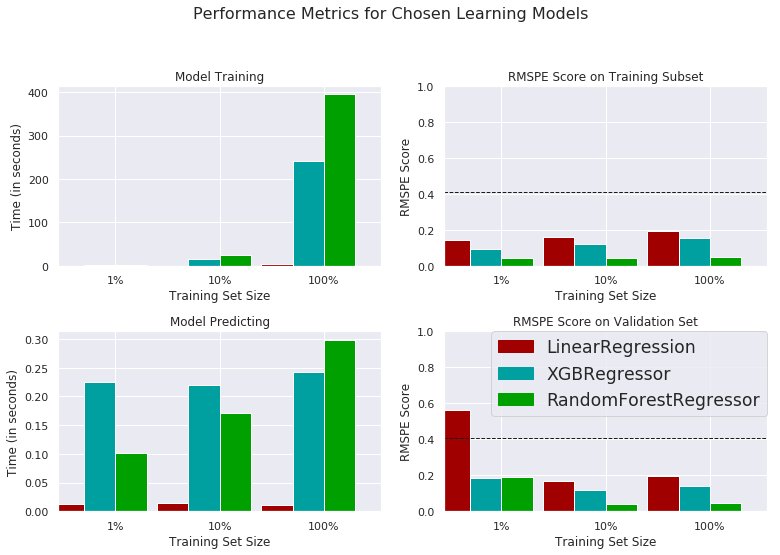

In [592]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost as xgb


seed = 42
# Initialize models
clf_A = LinearRegression()
clf_B = RandomForestRegressor(random_state=seed)
clf_C = XGBRegressor(random_state=seed)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(X_train.shape[0]*0.01)
samples_10 = int(X_train.shape[0]*0.1)
samples_100 = X_train.shape[0]

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train[features], y_train, X_valid[features], y_valid)
        
# Run metrics visualization for the chosen learning models 
vs.evaluate(results, naive_error)

In [594]:
def show_result(results):
    for k, learner in enumerate(results.keys()):
        print learner
        for j, metric in enumerate(['train_time', 'rmspe_train', 'pred_time', 'rmspe_val']):
            print " " + metric
            print " 1%        10%       100%"
            print " %.5f   %.5f   %.5f " % (results[learner][0][metric],results[learner][1][metric],results[learner][2][metric])

show_result(results)

LinearRegression
 train_time
 1%        10%       100%
 0.02277   0.24828   4.50656 
 rmspe_train
 1%        10%       100%
 0.14405   0.16239   0.19326 
 pred_time
 1%        10%       100%
 0.01190   0.01388   0.01165 
 rmspe_val
 1%        10%       100%
 0.56020   0.16725   0.19362 
XGBRegressor
 train_time
 1%        10%       100%
 1.54158   15.90852   241.01569 
 rmspe_train
 1%        10%       100%
 0.09593   0.12075   0.15288 
 pred_time
 1%        10%       100%
 0.22423   0.21947   0.24332 
 rmspe_val
 1%        10%       100%
 0.18283   0.11641   0.14277 
RandomForestRegressor
 train_time
 1%        10%       100%
 1.99506   25.34112   395.26783 
 rmspe_train
 1%        10%       100%
 0.04515   0.04431   0.04767 
 pred_time
 1%        10%       100%
 0.10138   0.17072   0.29855 
 rmspe_val
 1%        10%       100%
 0.18902   0.04268   0.04487 


* __XGBoost__

In [635]:
params = {'objective': 'reg:linear',
          'booster' : 'gbtree',
          'eta': 0.02,
          'max_depth': 10,
          'subsample': 0.9,
          'colsample_bytree': 0.7,
          'silent': 1,
          'seed': 1301
          }

num_boost_round = 20000


dtrain = xgb.DMatrix(X_train[features], y_train)
dvalid = xgb.DMatrix(X_valid[features], y_valid)


watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

print 'training beging ................'


gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
               early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=250)


print 'training end ...................'

training beging ................
[0]	train-rmse:8.07708	eval-rmse:8.10066	train-rmspe:0.999835	eval-rmspe:0.999839
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.


KeyboardInterrupt: 

In [581]:
print('performing validation')
yhat = gbm.predict(xgb.DMatrix(X_valid[features]))

# valid_result = pd.DataFrame({'Sales': np.expm1(yhat)})
# valid_result.to_csv('valid_basic.csv', index=False)
error = rmspe(X_valid.Sales.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

performing validation
RMSPE: 0.025991


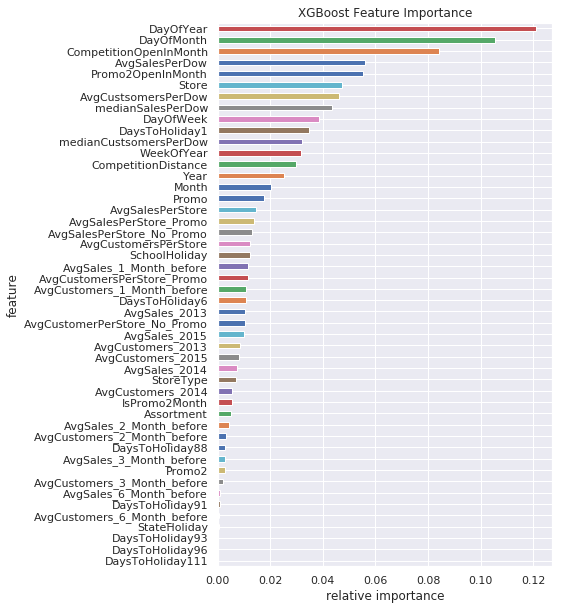

In [596]:
import operator

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

create_feature_map(features)
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum() 

featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure() 

## 测试

### 测试集

In [583]:
print('Make predictions on the test set')
dtest = xgb.DMatrix(test_df[features])
test_probs = gbm.predict(dtest)

# output
result = pd.DataFrame({'Id': df_test['Id'], 'Sales': np.expm1(test_probs) * 0.98 })
result.to_csv('Rossman_Kaggle_Submission_0908_2128_with98.csv', index=False)

Make predictions on the test set


### 结果可视化

In [600]:
valid_result = pd.DataFrame({'Sales': np.expm1(yhat)})
valid_result.to_csv('Rossman_Kaggle_Submission_0908_1850_with98.csv', index=False)

In [603]:
xgb_result = pd.read_csv('Rossman_Kaggle_Submission_0908_1850_with98.csv')


X_valid['pred'] = xgb_result.Sales.values

/home/zjz/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


KeyError: 'Date'

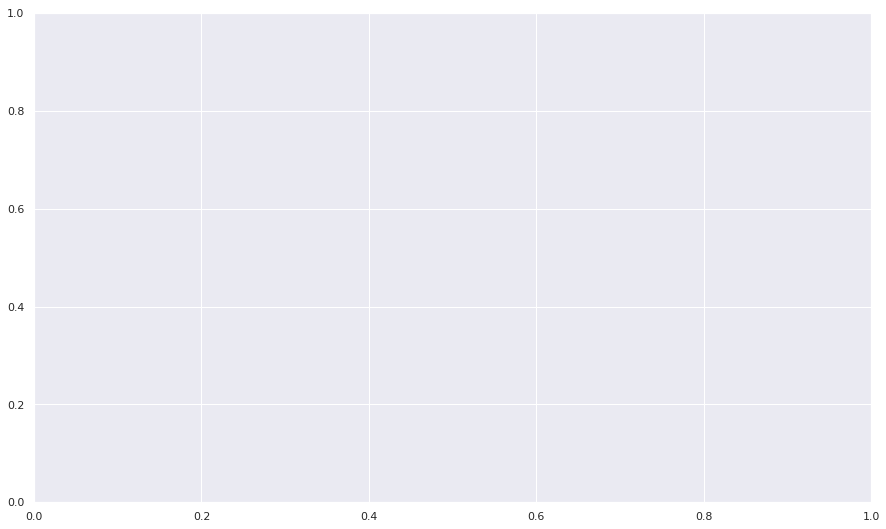

In [604]:
vis_store_df = X_valid[X_valid['Store'] == 1]

fig, ax = plt.subplots(1,1,figsize=(15,9))
ax.plot_date(vis_store_df['Date'], vis_store_df['Sales'], color='r', label='actual sales', linestyle="-")
ax.plot_date(vis_store_df['Date'], vis_store_df['pred_0903_1900'], color='b', label='predict sales', linestyle="-")

ax.legend()
ax.set_title('Store=1')

Text(0.5,1,'Store=102')

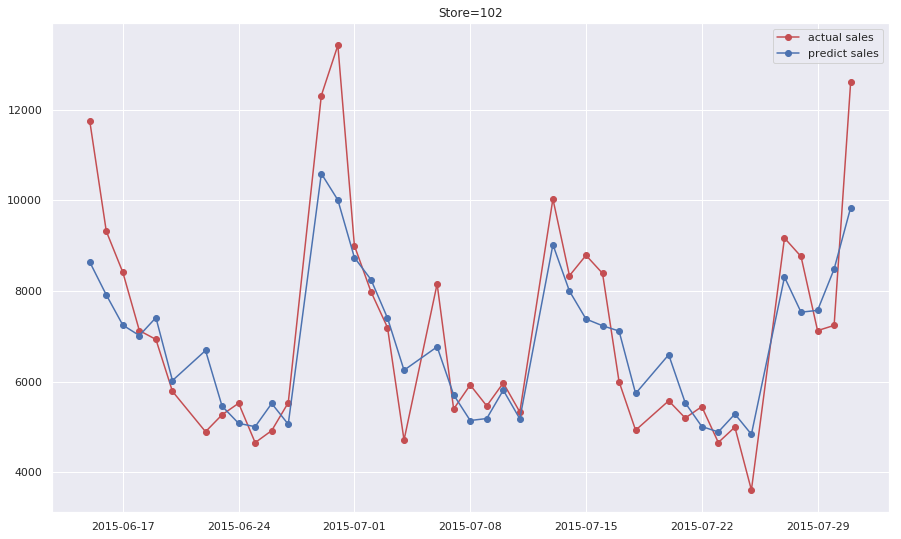

In [186]:
vis_store_df = X_valid[X_valid['Store'] == 102]

fig, ax = plt.subplots(1,1,figsize=(15,9))
ax.plot_date(vis_store_df['Date'], vis_store_df['Sales'], color='r', label='actual sales', linestyle="-")
ax.plot_date(vis_store_df['Date'], vis_store_df['pred_0903_1900'], color='b', label='predict sales', linestyle="-")

ax.legend()
ax.set_title('Store=102')

Text(0.5,1,'Store=909')

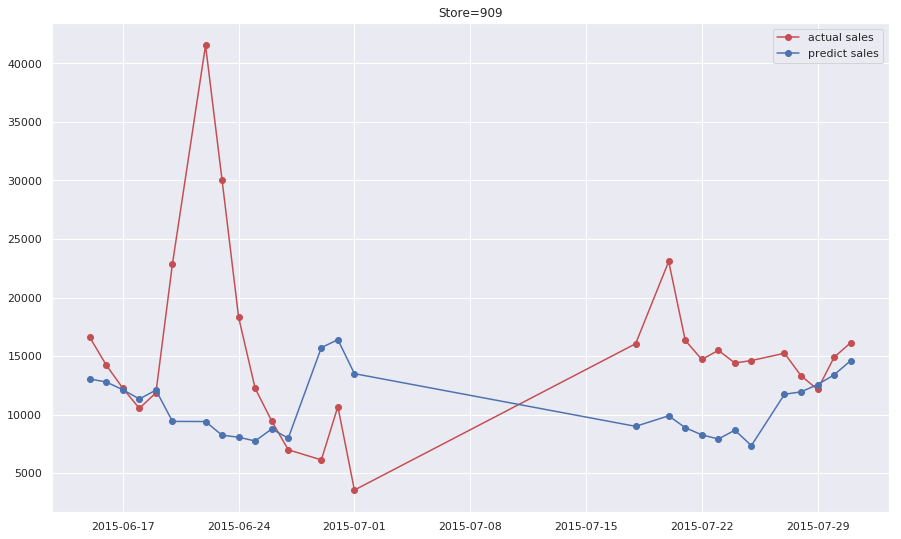

In [201]:
vis_store_df = X_valid[X_valid['Store'] == 909]

fig, ax = plt.subplots(1,1,figsize=(15,9))
ax.plot_date(vis_store_df['Date'], vis_store_df['Sales'], color='r', label='actual sales', linestyle="-")
ax.plot_date(vis_store_df['Date'], vis_store_df['pred_0903_1900'], color='b', label='predict sales', linestyle="-")

ax.legend()
ax.set_title('Store=909')